# Research Question:
### What are the most influential variables on the severity of accidents?

Useful Paper:
    https://www.sciencedirect.com/science/article/pii/S2590198223000611

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import holidays
from datetime import datetime, timezone
from pyspark.ml.classification import RandomForestClassifier, BinaryLogisticRegressionSummary
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Load Data

In [4]:
#Instantiate Spark Session
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())
spark.sparkContext.setLogLevel("ERROR") #supress warnings

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/17 22:00:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read in Dataset
df = spark.read.parquet("final_dataset_revised.parquet")
df.show(5)

+--------+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+
|Severity|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|
+--------+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+
|       2|         21|      85|      30|         1|        10|  

In [6]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7026806
DataFrame Columns count : 23


# Sampling

In [7]:
# Check Class Imbalance
cts = df.groupBy("Severity").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+--------+-------+------------------+
|Severity|  count|           percent|
+--------+-------+------------------+
|       1|  65142|0.9270499285165977|
|       3|1123799|15.993027272988611|
|       4| 178821|2.5448404296347444|
|       2|5659044| 80.53508236886005|
+--------+-------+------------------+



## Binary Classification

In [8]:
# Binary Classification (1 or 2 vs 3 or 4)
df = df.withColumn('Severity_Binary', when((col("Severity")==1) | (col("Severity")==2), 0).otherwise(1))
df = df.drop('Severity')
df.show(5)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Severity_Binary|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+
|         21|      85|      30|         1| 

In [9]:
# Check Class Imbalance
cts = df.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1302620|18.537867702623352|
|              0|5724186| 81.46213229737664|
+---------------+-------+------------------+



In [10]:
# Undersample each class by 80% of the smallest class
sample = (cts.select("count").rdd.min()[0])*0.8

class0 = sample/(cts.select("count").where(cts.Severity_Binary == '0').rdd.min()[0])
class1 = sample/(cts.select("count").where(cts.Severity_Binary == '1').rdd.min()[0])

# Split Data by Class - Downsampling

# Create a temporary view to use SQL
df.createOrReplaceTempView("data_view")

# Calculate fractions for each class
#fractions = df.groupBy("Severity").count().rdd.map(lambda row: (row[0], 0.8)).collectAsMap() #samples 80% of each class
fractions = {0: class0, 1: class1} #downsample each class to 80% of the smallest class

# Use stratified sampling to maintain class distribution
train_data = df.sampleBy("Severity_Binary", fractions, seed=42)
test_data = df.subtract(train_data)

In [11]:
# Print Overall % Sampled from DF
print(train_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
train_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / train_data.count())*100).show()

29.662054139533666
+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1041934|49.989756728294225|
|              0|1042361|50.010243271705775|
+---------------+-------+------------------+



In [12]:
# Print Overall % Sampled from DF
print(test_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
test_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / test_data.count())*100).show()

54.546560699128456


+---------------+-------+-----------------+
|Severity_Binary|  count|          percent|
+---------------+-------+-----------------+
|              1| 233407|6.089596833295894|
|              0|3599474| 93.9104031667041|
+---------------+-------+-----------------+



# Modeling

In [13]:
# Select all features except target variable
feature_list = []
for col in df.columns:
    if col == 'Severity_Binary':
        continue
    else:
        feature_list.append(col)

features_list = ['Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weekday',
 'Rush Hour',
 'Rain',
 'Snow',
 'SeasonVec',
 'SeasonVec2',
 'SeasonVec3',
 'Astronomical_TwilightIndex',
 'Interstate Indicator',
 'Sex ratio (males per 100 females)',
 'Percent_Age_15-19',
 'Percent_Age_20-24',
 'Percent_Age_65_over',
 'MedianIncome',
 'Urban_Ratio',
 'Traffic_Interference',
 'Traffic_Intersection',
 'Destination']       
        
# Vectorize Features
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')

### Check for Multicollinearity

In [14]:
# Assemble features into a vector
df_vector = assembler.transform(df)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=features_list, index=features_list)

# Get the pairs of columns with correlation greater than 0.5
high_corr_pairs = []
for col1 in corr_matrix_pd.columns:
    for col2 in corr_matrix_pd.columns:
        if col1 != col2 and ((corr_matrix_pd[col1][col2] > 0.4) | (corr_matrix_pd[col1][col2] < -0.4)):
            high_corr_pairs.append((col1, col2, corr_matrix_pd[col1][col2]))

print(high_corr_pairs)

[('Temperature(F)', 'SeasonVec', -0.5175782168440152), ('SeasonVec', 'Temperature(F)', -0.5175782168440152), ('Percent_Age_15-19', 'Percent_Age_20-24', 0.46583032647322975), ('Percent_Age_20-24', 'Percent_Age_15-19', 0.46583032647322975), ('Percent_Age_20-24', 'Percent_Age_65_over', -0.40007330340697406), ('Percent_Age_65_over', 'Percent_Age_20-24', -0.40007330340697406)]


In [15]:
# Create a RandomForestClassifier
rf = RandomForestClassifier(labelCol="Severity_Binary", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [7,9,10,11,12,15]) \
    .addGrid(rf.maxDepth, [6,7,8,9,10]) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1.0),
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions on the test set
predictions = cvModel.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1.0)
recall = evaluator.evaluate(predictions)
print("Recall: ", recall)

# Get and save the best model
bestModel = cvModel.bestModel
bestModel.save("best_rf_model")
print(bestModel.stages[-1]._java_obj.paramMap()) 

Recall:  0.6385841041614004
{
	RandomForestClassifier_42e922fe0dd5-featuresCol: features,
	RandomForestClassifier_42e922fe0dd5-labelCol: Severity_Binary,
	RandomForestClassifier_42e922fe0dd5-maxDepth: 10,
	RandomForestClassifier_42e922fe0dd5-numTrees: 8
}


In [24]:
train_data_s = assembler.transform(train_data)
test_data_s = assembler.transform(test_data)

# Define parameter ranges
param_ranges = {
    "maxDepth": [3,4,5,6],
    "numTrees": [3,4,5,6]
}

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction")

# Perform sensitivity analysis
results = []
for maxDepth in param_ranges["maxDepth"]:
    for numTrees in param_ranges["numTrees"]:
        # Create a logistic regression model
        rf = RandomForestClassifier(labelCol="Severity_Binary", featuresCol="features", maxDepth=maxDepth, numTrees=numTrees)

        # Fit the model
        model = rf.fit(train_data_s)

        # Make predictions
        predictions = model.transform(test_data_s)

        # Evaluate the model
        recall = evaluator.evaluate(predictions, {evaluator.metricName:"truePositiveRateByLabel", evaluator.metricLabel: 1.0})
        f1 = evaluator.evaluate(predictions, {evaluator.metricName:"f1"})
        accuracy = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})

        # Store the results
        results.append([maxDepth, numTrees, recall, f1, accuracy])

# Save and Print Results
sensitivity_analysis = pd.DataFrame(columns=['maxDepth', 'numTrees', 'recall', 'f1', 'accuracy'])
for i,result in enumerate(results):
    sensitivity_analysis.loc[i] = result
print(sensitivity_analysis)

    maxDepth  numTrees    recall        f1  accuracy
0        3.0       3.0  0.483190  0.837051  0.787777
1        3.0       4.0  0.474390  0.843095  0.797167
2        3.0       5.0  0.484707  0.836523  0.786945
3        3.0       6.0  0.482261  0.837761  0.788875
4        4.0       3.0  0.481854  0.838415  0.789876
5        4.0       4.0  0.473096  0.844379  0.799159
6        4.0       5.0  0.505268  0.831192  0.778498
7        4.0       6.0  0.482209  0.837988  0.789221
8        5.0       3.0  0.485958  0.838505  0.789930
9        5.0       4.0  0.483370  0.841264  0.794180
10       5.0       5.0  0.513476  0.828793  0.774750
11       5.0       6.0  0.495204  0.834375  0.783487
12       6.0       3.0  0.487757  0.839842  0.791925
13       6.0       4.0  0.497012  0.838522  0.789732
14       6.0       5.0  0.565814  0.806749  0.741452
15       6.0       6.0  0.503412  0.834983  0.784250


## Load Saved Best Model

In [19]:
# Load the saved best model
loadedCvModel = PipelineModel.load("best_rf_model")

## Evaluation Metrics

Weighted Precision: 0.9166656036655999
Weighted Recall: 0.705070415700357
Weighted F1 Score: 0.7816092396946951
Accuracy: 0.705070415700357


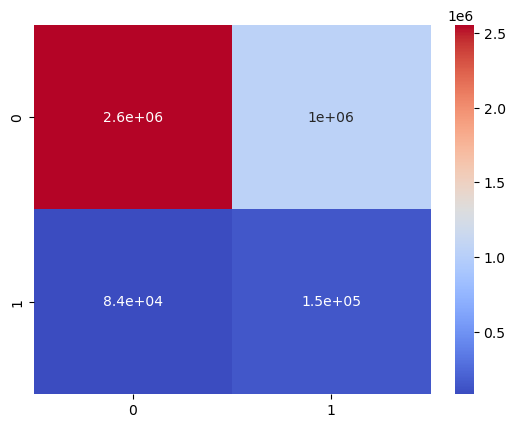

Area Under ROC: 0.6739829041329722


In [20]:
# Further Metrics on Best Model
pred = loadedCvModel.transform(test_data)

#Evaluate (Confusion Matrix, Accuracy, Weighted Precision, Recall, and F1 Score)
predictionAndLabels = pred.select("prediction", "Severity_Binary")
rdd = predictionAndLabels.rdd.map(lambda x: tuple(map(float, x)))
multi_metrics = MulticlassMetrics(rdd)

# Get precision, recall, and F1-score for each class
print(f'Weighted Precision: {multi_metrics.weightedPrecision}') #would expect to be good when test sample has high majority 0 class
print(f'Weighted Recall: {multi_metrics.weightedRecall}')
print(f'Weighted F1 Score: {multi_metrics.weightedFMeasure()}') #would like to optimize this (balance of precision and recall)
print(f'Accuracy: {multi_metrics.accuracy}') #could be skewed with imbalanced test set

# Plot confusion matrix
cf = multi_metrics.confusionMatrix().toArray()
cf_df = pd.DataFrame(cf, columns=['0', '1'])
sns.heatmap(cf_df, annot=True, cmap="coolwarm")
plt.show()

# AUC Score
binary_metrics = BinaryClassificationMetrics(rdd)
auc = binary_metrics.areaUnderROC
print("Area Under ROC:", auc)

## Feature Importance

In [21]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances

# Create a mapping between feature names and their importance scores
feature_importance_dict = {}
feature_names = assembler.getInputCols()
for i, feature_name in enumerate(feature_names):
    feature_importance_dict[feature_name] = feature_importances[i]

# Sort the feature importance dictionary by score in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature_name, importance_score in sorted_feature_importances:
    print(f"{feature_name}: {importance_score}")

Percent_Age_15-19: 0.518878784456281
Wind_Speed: 0.09576491037432958
Pressure: 0.05281391061787871
Traffic_Intersection: 0.04722033637459553
SeasonVec: 0.02611992358675484
Temperature: 0.021719254910183505
Urban_Ratio: 0.02112589871150526
Traffic_Interference: 0.01336438518963722
Sex_ratio: 0.010840733774332747
Percent_Age_20-24: 0.01003386507403679
Percent_Age_65_over: 0.009698795049894899
MedianIncome: 0.007710452704701987
Destination: 0.00552247045510661
Humidity: 0.005407462757400013
Weekday: 0.00514999496603996
Astronomical_TwilightIndex: 0.005030342382341946
Visibility: 0.002926641855305248
Rain: 0.0020337981907904996
Interstate_Indicator: 0.0013973151122822778
Snow: 0.0013390093290400154
Rush_Hour: 0.0010441126536839256
Precipitation: 1.959547969277274e-06
